# Просепт (машинное обучение)

<font size = 4> **Описание проекта**

Заказчик производит несколько сотен различных товаров бытовой и промышленной химии, а затем продаёт эти товары через дилеров. Дилеры, в свою очередь, занимаются розничной продажей товаров в крупных сетях магазинов и на онлайн площадках.    
Для оценки ситуации,  управления ценами и  бизнесом в целом, заказчик периодически собирает информацию о том, как дилеры продают их товар. Для этого они парсят сайты дилеров, а затем сопоставляют товары и цены.    
Зачастую описание товаров на сайтах дилеров отличаются от того описания, что даёт заказчик. Например, могут добавляться новый слова ("универсальный", "эффективный"), объём (0.6 л --- 600 мл). Поэтому сопоставление товаров дилеров с товарами производителя делается вручную.

<font size = 4> **Цель проекта**

Разработка решения, которое отчасти автоматизирует процесс сопоставления товаров. Основная идея - предлагать несколько товаров заказчика, которые с наибольшей вероятностью соответствуют размечаемому товару дилера. 
Предлагается реализовать это решение, как онлайн сервис, открываемый в веб-браузере. 

**Выбор наиболее вероятных подсказок делается методами машинного обучения.**
    

<font size = 4> **План проекта** </font>    

**1.  Изучение данных.**     

1.1  Установка библиотек.    
1.2  Импорт библиотек и методов работы с данными.     
1.3  Считывание данных из файлов.     
  

**2.  Анализ данных.**     

2.1  Анилиз длин текстов.     
2.2  Частотный анализ текстов.       


**3.  Предобработка данных и ранжирование объектов.**     

3.1  Фильтр необходимых признаков.    
3.2  Обработка текстов.    
3.3  Написание функций.     
3.4  Исследование метода мешка слов.     
3.5  Исследование метода TF-IDf.    
3.5  Использование эмбедингов.     


**4.  Вывод.**     
   

**5.  Продолжение работы (исследование, эксперименты).**      

## Изучение данных

### Установим библиотеки.

### Выполним импорт нужных библиотек и методов работы с данными.

In [1]:
# Импорт стандартных библиотек
import warnings
import re

# Импорт сторонних библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import torch
import joblib

# Отключение предупреждений
pd.options.mode.chained_assignment = None
warnings.filterwarnings('ignore')

In [2]:
# Импорт моделей машинного обучения
from sklearn.neighbors import NearestNeighbors

# Импорт способов векторизации текстов
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.feature_extraction.text import TfidfVectorizer

# Импорт предобученной модели для получения эмбедингов
from sentence_transformers import SentenceTransformer

# Импорт классов необходимых для дообучения моделей
from sentence_transformers import InputExample, losses
from torch.utils.data import DataLoader

# Импорт индикатора выполнения
from tqdm import notebook

# Импорт токенайзера и стоп - слов из nltk
from nltk import word_tokenize
from nltk.corpus import stopwords

# Импорт библиотеки для создания визуализации частотности слов 
from wordcloud import WordCloud

# Импорт способа использования синтаксиса Markdown при вводе текста в ячейке
from IPython.display import Markdown

# Задание константы (Ответ на главный вопрос жизни, вселенной и всего такого)
RANDOM_STATE = 42

### Считываем данные из CSV-файла в датафрейм и сохраняем в переменную.

#### Рассмотрим файл `marketing_dealer.csv`.

In [3]:
dealer = pd.read_csv('d:/Data_science/Hackathons/Prosept/data/marketing_dealer.csv', sep=';')
dealer

id                      name
0    1              Moi_vibor_WB
1    2                     Akson
2    3                     Bafus
3    5                 Castorama
4    6                  Cubatora
5    7                     Komus
6    9                 Megastroy
7   10               OnlineTrade
8   11                 Petrovich
9   12                     sdvor
10  13                  simaLand
11  14                    VegosM
12  15            Vse_instrumeni
13  16                     Vimos
14   4                 Baucenter
15   8              Leroy_Merlin
16  18  Мasterstroy_spb_OZON\r\n
17  17           Unicleaner_OZON

#### Рассмотрим файл `marketing_product.csv`.

In [4]:
base = pd.read_csv('d:/Data_science/Hackathons/Prosept/data/marketing_product.csv', sep=';', index_col=[0])
base

id    article        ean_13  \
0    245      008-1  4.680008e+12   
1      3     242-12           NaN   
2    443  0024-06 с  4.680008e+12   
3    147      305-2  4.610093e+12   
4    502   0024-7 б           NaN   
..   ...        ...           ...   
491  127      152-5  4.680008e+12   
492  160      289-1  4.680008e+12   
493   74     192-05  4.680008e+12   
494   34      186-5  4.680008e+12   
495   52    113-075  4.680008e+12   

                                                  name    cost  \
0    Антисептик невымываемыйPROSEPT ULTRAконцентрат...  360.00   
1       Антигололед - 32 PROSEPTготовый состав / 12 кг  460.16   
2             Герметик акриловый цвет сосна, ф/п 600мл  307.00   
3    Кондиционер для белья с ароматом  королевского...  157.73   
4                 Герметик акриловой  цвет Белый, 7 кг     NaN   
..                                                 ...     ...   
491  Средство для уборки помещений после пожара с д...  849.78   
492  Жидкое моющее средство для стирки шерсти, шелк...  201.00   
493  Средство для чистки гриля и духовых шкафовCook...  108.60   
494  Средство для мытья полов с полимерным покрытие...  579.74   
495  Средство усиленного действия для удаления ржав...   75.00   

     recommended_price  category_id  \
0                858.0         20.0   
1               1075.0          NaN   
2                644.0         25.0   
3                342.0         29.0   
4                  NaN          NaN   
..                 ...          ...   
491             1985.0         40.0   
492              436.0         23.0   
493              254.0         49.0   
494             1354.0         40.0   
495              176.0         52.0   

                                             ozon_name  \
0    Антисептик невымываемый для ответственных конс...   
1                                                  NaN   
2    Герметик акриловый для швов для деревянных дом...   
3    Кондиционер для белья "Королевский Ирис" Prose...   
4                                                  NaN   
..                                                 ...   
491  Средство для уборки помещений после пожара с д...   
492  Гель для стирки шерсти, шелка и деликатных тка...   
493  Cредство для чистки гриля и духовок Cooky Gril...   
494  Профессиональное средство для мытья полов с по...   
495  Усиленное средство для удаления ржавчины и мин...   

                                               name_1c  \
0    Антисептик невымываемый для ответственных конс...   
1       Антигололед - 32 PROSEPTготовый состав / 12 кг   
2             Герметик акриловый цвет сосна, ф/п 600мл   
3    Кондиционер для белья "Королевский Ирис" Prose...   
4                                                  NaN   
..                                                 ...   
491  Средство для уборки помещений после пожара с д...   
492  Гель для стирки шерсти, шелка и деликатных тка...   
493  Cредство для чистки гриля и духовок Cooky Gril...   
494  Профессиональное средство для мытья полов с по...   
495  Усиленное средство для удаления ржавчины и мин...   

                                               wb_name  ozon_article  \
0    Антисептик невымываемый для ответственных конс...   189522705.0   
1                                                  NaN           NaN   
2    Герметик акриловый для швов для деревянных дом...   189522735.0   
3    Кондиционер для белья "Королевский Ирис" Prose...   339377922.0   
4                                                  NaN   189522867.0   
..                                                 ...           ...   
491  Средство для уборки помещений после пожара с д...   451969758.0   
492  Гель для стирки шерсти, шелка и деликатных тка...   446058619.0   
493  Cредство для чистки гриля и духовок Cooky Gril...   449311005.0   
494  Профессиональное средство для мытья полов с по...   451107584.0   
495  Усиленное средство для удаления ржавчины и мин...   413264558.0   

      wb_article ym_article wb_article_t

In [5]:
# Пропуски в base['name']
base[(base['name'].isna()) | (base['id'] == 436)]

id   article        ean_13 name   cost  recommended_price  category_id  \
23  503  0024-7 о           NaN  NaN    NaN                NaN          NaN   
35  504   w022-05           NaN  NaN    NaN                NaN          NaN   
98  436  Р1 09005  4.680008e+12       500.0              600.0          NaN   

   ozon_name name_1c wb_name  ozon_article   wb_article ym_article  \
23       NaN     NaN     NaN           NaN  150126213.0        NaN   
35       NaN     NaN     NaN           NaN          NaN        NaN   
98       NaN     NaN     NaN           NaN          NaN        NaN   

   wb_article_td  
23           NaN  
35           NaN  
98           NaN

In [6]:
# Пропуски в base['name_1с']
base[base['name_1c'].isna()]

id     article        ean_13  \
4    502    0024-7 б           NaN   
23   503    0024-7 о           NaN   
31   118      273-20           NaN   
32   119      274-20           NaN   
35   504     w022-05           NaN   
46   182    P1 11005           NaN   
47   181    P1 11800           NaN   
60   186    P1 06005           NaN   
98   436    Р1 09005  4.680008e+12   
102  433  D1 01050-3           NaN   
115  456      М007-2  4.610093e+12   

                                                  name    cost  \
4                 Герметик акриловой  цвет Белый, 7 кг     NaN   
23                                                 NaN     NaN   
31   Средство усиленного действия для чистки коптил...  3730.0   
32   Средство низкопенное  для  очистки  алюминия и...  2818.0   
35                                                 NaN     NaN   
46   Cредство для рук гигиеническое с антибактериал...   565.0   
47   Cредство для рук гигиеническое с антибактериал...   155.0   
60   Жидкое мыло с антибактериальным компонентом дл...   492.0   
98                                                       500.0   
102   Кожный антисептик PROF DZ готовый состав / 0,1 л   112.8   
115  Антисептик для рук PROSEPT PROF DZ, 2 штуки*10...   112.0   

     recommended_price  category_id  \
4                  NaN          NaN   
23                 NaN          NaN   
31              8712.0          NaN   
32              6581.0          NaN   
35                 NaN          NaN   
46              1319.0          NaN   
47               361.0          NaN   
60              1067.0          NaN   
98               600.0          NaN   
102              226.0          NaN   
115              224.0         21.0   

                                             ozon_name name_1c wb_name  \
4                                                  NaN     NaN     NaN   
23                                                 NaN     NaN     NaN   
31                                                 NaN     NaN     NaN   
32                                                 NaN     NaN     NaN   
35                                                 NaN     NaN     NaN   
46                                                 NaN     NaN     NaN   
47                                                 NaN     NaN     NaN   
60                                                 NaN     NaN     NaN   
98                                                 NaN     NaN     NaN   
102                                                NaN     NaN     NaN   
115  Антисептик для рук PROSEPT PROF DZ, 2 штуки*10...     NaN     NaN   

     ozon_article   wb_article  ym_article wb_article_td  
4     189522867.0  150126216.0    0024-7-б           NaN  
23            NaN  150126213.0         NaN           NaN  
31            NaN          NaN         NaN           NaN  
32            NaN          NaN         NaN           NaN  
35            NaN          NaN         NaN           NaN  
46            NaN          NaN         NaN           NaN  
47            NaN          NaN         NaN           NaN  
60            NaN          NaN         NaN           NaN  
98            NaN          NaN         NaN           NaN  
102           NaN  150119529.0         NaN           NaN  
115           NaN          NaN  D1-01100-2           NaN

**Замечание:**  
Признаком для сравнения текстов выберем `name_1c` по просьбе заказчика.

In [7]:
# Удаляем строки с пропусками в столбце "name_1c"
base = base[base['name_1c'].notna()]

**Замечание:**  
Можно, также, попробовать заменить пропущенные значения в `name_1c` имена товаров из столбца `name`.

#### Рассмотрим файл `marketing_dealer.csv`.

In [8]:
parsing = pd.read_csv('d:/Data_science/Hackathons/Prosept/data/marketing_dealerprice.csv', sep=';')
parsing

id product_key   price  \
0          2      546227   233.0   
1          3      546408   175.0   
2          4      546234   285.0   
3          5      651258   362.0   
4          6      546355   205.0   
...      ...         ...     ...   
20411  20566   534517451   823.0   
20412  20567   530308963   418.0   
20413  20568   531730388  2986.0   
20414  20569  1090913025   579.0   
20415  20570  1077090171  2623.0   

                                             product_url  \
0      https://akson.ru//p/sredstvo_universalnoe_pros...   
1      https://akson.ru//p/kontsentrat_prosept_multip...   
2      https://akson.ru//p/sredstvo_dlya_chistki_lyus...   
3      https://akson.ru//p/udalitel_rzhavchiny_prosep...   
4      https://akson.ru//p/sredstvo_moyushchee_dlya_b...   
...                                                  ...   
20411              https://www.ozon.ru/product/534517451   
20412              https://www.ozon.ru/product/530308963   
20413              https://www.ozon.ru/product/531730388   
20414             https://www.ozon.ru/product/1090913025   
20415             https://www.ozon.ru/product/1077090171   

                                            product_name        date  \
0      Средство универсальное Prosept Universal Spray...  2023-07-11   
1      Концентрат Prosept Multipower для мытья полов,...  2023-07-11   
2      Средство для чистки люстр Prosept Universal An...  2023-07-11   
3      Удалитель ржавчины PROSEPT RUST REMOVER 0,5л 0...  2023-07-11   
4      Средство моющее для бани и сауны Prosept Multi...  2023-07-11   
...                                                  ...         ...   
20411  Огнебиозащита для древесины PROSEPT 2 группа, ...  2023-07-31   
20412       Антисептик многофункциональный ФБС, ГОСТ 5 л  2023-07-31   
20413       Средство для удаления ржавчины PROSEPT, 1 шт  2023-07-31   
20414  Герметик акриловый межшовный для деревянных ко...  2023-07-31   
20415  Краска-грунт фасадная для плит OSB Proff 3 в 1...  2023-07-31   

       dealer_id  
0              2  
1              2  
2              2  
3              2  
4              2  
...          ...  
20411         18  
20412         18  
20413         18  
20414         18  
20415         18  

[20416 rows x 7 columns]

In [9]:
# Вывод количества пропусков на экран
parsing.isna().sum()

id                0
product_key       0
price             0
product_url     234
product_name      0
date              0
dealer_id         0
dtype: int64

In [10]:
# Получение информации о диллере с пропущенными url
parsing[parsing['product_url'].isna()]['dealer_id'].unique()

array([7], dtype=int64)

**Замечание:**  
Для диллера № 7 `Komus` данные по `url` отсутствуют.

In [11]:
# Подсчёт дубликатов
parsing['product_name'].duplicated().sum()

18463

In [12]:
# Количество уникальных значений
len(parsing['product_name'].unique())

1953

**Замечание:**  
В этой таблице очень много дубликатов. Для обучения и тестирования модели они нам не понадобятся. В имеющихся данных всего 1953 уникальных названий.

In [13]:
# Удаление дубликатов
parsing_clear = parsing[~parsing['product_name'].duplicated()]
parsing_clear

id product_key   price  \
0          2      546227   233.0   
1          3      546408   175.0   
2          4      546234   285.0   
3          5      651258   362.0   
4          6      546355   205.0   
...      ...         ...     ...   
20159  20311      856988  2472.0   
20162  20314      856956   445.0   
20168  20320      651260   484.0   
20284  20439   900996549   294.0   
20401  20556   528911039   507.0   

                                             product_url  \
0      https://akson.ru//p/sredstvo_universalnoe_pros...   
1      https://akson.ru//p/kontsentrat_prosept_multip...   
2      https://akson.ru//p/sredstvo_dlya_chistki_lyus...   
3      https://akson.ru//p/udalitel_rzhavchiny_prosep...   
4      https://akson.ru//p/sredstvo_moyushchee_dlya_b...   
...                                                  ...   
20159  https://akson.ru//p/kraska_grunt_fasadnaya_pro...   
20162  https://akson.ru//p/kraska_grunt_fasadnaya_pro...   
20168  https://akson.ru//p/sredstvo_dlya_udaleniya_kl...   
20284              https://www.ozon.ru/product/900996549   
20401              https://www.ozon.ru/product/528911039   

                                            product_name        date  \
0      Средство универсальное Prosept Universal Spray...  2023-07-11   
1      Концентрат Prosept Multipower для мытья полов,...  2023-07-11   
2      Средство для чистки люстр Prosept Universal An...  2023-07-11   
3      Удалитель ржавчины PROSEPT RUST REMOVER 0,5л 0...  2023-07-11   
4      Средство моющее для бани и сауны Prosept Multi...  2023-07-11   
...                                                  ...         ...   
20159  Краска-грунт фасадная PROSEPT Proff 3 в 1 для ...  2023-07-31   
20162  Краска-грунт фасадная PROSEPT OSB Proff 3 в 1 ...  2023-07-31   
20168  Средство для удаления клейкой ленты, клея, нак...  2023-07-31   
20284  Отбеливатель для древесины PROSEPT ECO 50 гото...  2023-07-31   
20401  Герметик акриловый межшовный для деревянных ко...  2023-07-31   

       dealer_id  
0              2  
1              2  
2              2  
3              2  
4              2  
...          ...  
20159          2  
20162          2  
20168          2  
20284         18  
20401         18  

[1953 rows x 7 columns]

**Замечание:**  
Остальсь 1953 строки.

#### Рассмотрим файл `marketing_productdealerkey.csv`.

In [14]:
match = pd.read_csv('d:/Data_science/Hackathons/Prosept/data/marketing_productdealerkey.csv', sep=';')
match

id        key  dealer_id  product_id
0        1     546227          2          12
1        2     651265          2         106
2        3     546257          2         200
3        4     546408          2          38
4        5     651258          2         403
...    ...        ...        ...         ...
1695  2019  530017190         18         267
1696  2020  530139882         18         286
1697  2021  534659036         18         129
1698  2022  898350801         18           1
1699  2023  534666258         18         128

[1700 rows x 4 columns]

In [15]:
# Количество уникальных значений полученных с помощью парсинга
len(match['key'].unique())

1700

In [16]:
# Количество уникальных значений из базы
len(match['product_id'].unique())

438

**Замечание:**  
Мы можем сопоставить не все имеющиеся данные. Проверочная таблица имеет информацию по 1700 уникальным названиям из данных парсинга и 438 из базы заказчика.

Для проверки работы модели предсказаний объединим данные из двух таблиц и оставим только те строки в которых присутствует необходимая нам информация.

## Анализ данных.

### Посмотрим на длины текстов.

In [17]:
# Регулярное выражение содержащее буквы на русском и английском языках и цифры
pattern = r'\w*[a-zA-Zа-яА-ЯёЁ0-9]+\w*'

In [18]:
# Преобразуем колонку с коментариями в список списков со словами из комментариев
name_list_base = []
for string in base['name_1c']: 
    name_list_base.append(re.findall(pattern, str(string)))
# Создадим список из длин комментариев
length_name_base = []
for comment in name_list_base:
    length_name_base.append(len(comment))

In [19]:
# Преобразуем колонку с коментариями в список списков со словами из комментариев
name_list_pars = []
for string in parsing_clear['product_name']: 
    name_list_pars.append(re.findall(pattern, str(string)))
# Создадим список из длин комментариев
length_name_pars = []
for comment in name_list_pars:
    length_name_pars.append(len(comment))

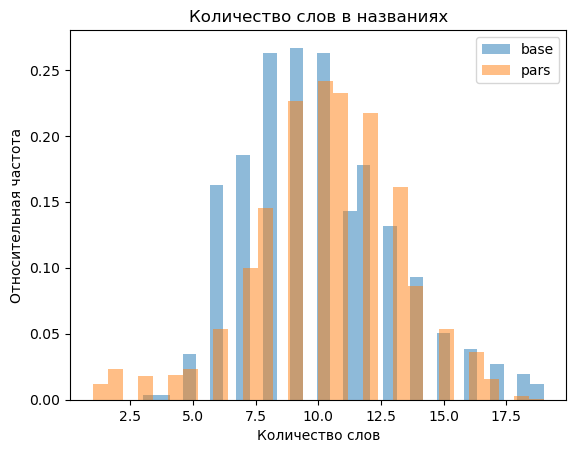

Минимальная и максимальная длины названия в base: 3 , 19
Минимальная и максимальная длины названия в pars: 1 , 19


In [20]:
# Построим гистограмму распределения комментариев по длинам
plt.hist(length_name_base, bins=30, alpha=0.5, density=True, label='base')
plt.hist(length_name_pars, bins=30, alpha=0.5, density=True, label='pars')
plt.legend(loc='upper right')
plt.xlabel('Количество слов');
plt.ylabel('Относительная частота');
plt.title('Количество слов в названиях');
plt.show()
print('Минимальная и максимальная длины названия в base:', min(length_name_base), ',', max(length_name_base))
print('Минимальная и максимальная длины названия в pars:', min(length_name_pars), ',', max(length_name_pars))

**Замечание:**  Длины названий не сильно отличаются в двух таблицах. Распределения похожи. 

In [21]:
# Вывод строк с короткими названиями из base
base['length'] = length_name_base
display(base[base['length'] < 5])

id   article        ean_13  \
8    505   СФ001-5  4.610093e+12   
297  162  С1 03500  4.680008e+12   

                                                  name   cost  \
8                Антисептик универсальный суперсильный  200.0   
297  Универсальный пятновыводительCandyготовый сост...  159.0   

     recommended_price  category_id  \
8                510.0         20.0   
297              371.0         39.0   

                                          ozon_name  \
8             Антисептик универсальный суперсильный   
297  Профессиональный пятновыводитель PROSEPT Candy   

                                            name_1c  \
8             Антисептик универсальный суперсильный   
297  Профессиональный пятновыводитель PROSEPT Candy   

                                            wb_name  ozon_article  \
8             Антисептик универсальный суперсильный           NaN   
297  Профессиональный пятновыводитель PROSEPT Candy   449818261.0   

      wb_article ym_article wb_article_td  length  
8            NaN        NaN           NaN       3  
297  150031995.0   С1-03500           NaN       4

In [22]:
# Вывод строк с короткими названиями из pars
parsing_clear['length'] = length_name_pars
display(parsing_clear[parsing_clear['length'] < 3].sample(5))

id product_key  price  \
482    479  1001472279  650.0   
468    465  1001472257  300.0   
479    476  1001472283  414.0   
469    466  1001472264  154.0   
1697  1698    44231997  450.0   

                                            product_url  \
482   https://www.castorama.ru/konts_t_d_myt_pos_v_p...   
468   https://www.castorama.ru/sredstvo-dlja-udaleni...   
479   https://www.castorama.ru/sr_vo_dlya_stir_chyer...   
469   https://www.castorama.ru/sr_vo_d_udal_rzhavch_...   
1697  https://www.wildberries.ru/catalog/44231997/de...   

                                           product_name        date  \
482   МоющеесредстводляпосудывпосудомоечноймашинеPro...  2023-07-11   
468    СредстводляудаленияцементаProseptСementСlean0,5л  2023-07-11   
479   ЖидкоесредстводлястиркичерныхтканейProseptCrys...  2023-07-11   
469     СредстводляудаленияржавчиныProseptBathAcid750мл  2023-07-11   
1697                                      Duty Graffiti  2023-07-11   

      dealer_id  length  
482           5       2  
468           5       2  
479           5       2  
469           5       1  
1697          1       2

**Замечание:**  
С данными в базе (`name_1c`) всё в порядке с названиями.
Данные пришедшие извне, скорее всего понадобится предобрабатывать - разделять "длинные" (склеенные) слова. 

### Выполним частотный анализ текстов.

Результато этого анализа является список слов, наиболее часто встречающихся в тексте. Частотный анализ также позволяет получить представление о тематике и основных понятиях текста. Визуализировать его результаты удобно в виде "облака слов" (`WordCloud`). Эта диаграмма содержит слова, размер шрифта которых отражает их популярность в тексте.

Графики `WordCloud` будем строить на основе токенов. Токены получим с помощью метода `word_tokenize` из библиотеки `nltk`.

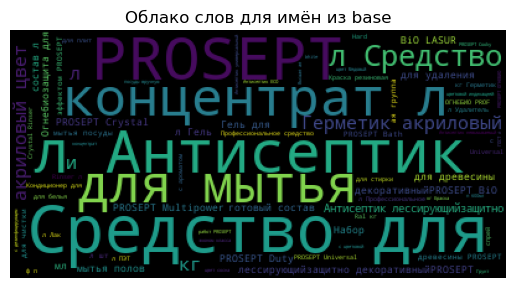

In [23]:
# Распаковка вложенных списков в один
extend_list_base = []
for sublist in name_list_base:
    extend_list_base.extend(sublist)
# Объединение всех токенов в одну строку
name_str_base = " ".join(extend_list_base)
# Построение графика "WordCloud"
wordcloud_base = WordCloud(background_color='black', random_state=RANDOM_STATE).generate(name_str_base)
plt.imshow(wordcloud_base)
plt.axis('off')
plt.title('Облако слов для имён из base')
plt.show()

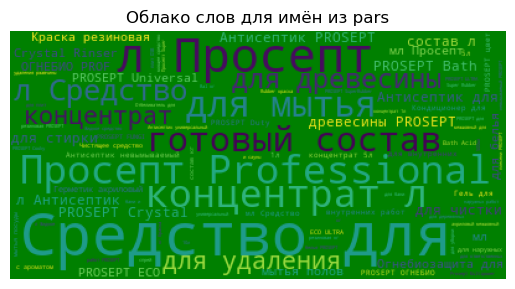

In [24]:
# Распаковка вложенных списков в один
extend_list_pars = []
for sublist in name_list_pars:
    extend_list_pars.extend(sublist)
# Объединение всех токенов в одну строку
name_str_pars = " ".join(extend_list_pars)
# Построение графика "WordCloud"
wordcloud_pars = WordCloud(background_color='green', random_state=RANDOM_STATE).generate(name_str_pars)
plt.imshow(wordcloud_pars)
plt.axis('off')
plt.title('Облако слов для имён из pars')
plt.show()

**Замечание:**  
В обеих таблицах, очень распространены слова: `Просепт`, `PROSEPT`, и т.п. Это название производителя. Известно что парсер заказчика настроен искать только товары собственного производства. Поэтому эти названия в векторном представлении, могут негативно повлиять на предсказывания модели.    
Возможно, лучше удалить эти слова.

## Предобработка данных и ранжирование объектов.

### Создадим таблицу для проверки работы моделей.

In [25]:
# Объединение тоблиц
parsing_match = parsing_clear.merge(match, how='left', left_on='product_key', right_on='key')
parsing_match = parsing_match.merge(base[['id', 'name_1c']], how='left', left_on='product_id', right_on='id')

# Удаление строк с пропусками
parsing_match = parsing_match[parsing_match['product_id'].notna()]
parsing_match = parsing_match[parsing_match['name_1c'].notna()]

# Приведение признака к целочисленному значению
parsing_match['product_id'] = parsing_match['product_id'].astype(int)
parsing_match = parsing_match.reset_index()

# Вывод таблицы
parsing_match.sample(5)

index  id_x product_key   price  \
724     741   997     1020955   929.0   
914     961  1216    20633200   852.0   
1001   1053  1305    25458231  1231.0   
8         8    10      857015   371.0   
331     336   357   200544164   746.0   

                                            product_url  \
724                    https://www.sima-land.ru/1284667   
914   https://www.vseinstrumenti.ru/product/antisept...   
1001  https://www.vseinstrumenti.ru/product/shpatlev...   
8     https://akson.ru//p/shpatlevka_zamazka_prosept...   
331                     https://www.bafus.ru/200544164/   

                                           product_name        date  \
724   Средство для чистки гриля и духовых шкафов Coo...  2023-07-11   
914   Антисептик PROSEPT ECO ULTRA невымываемый, кор...  2023-07-11   
1001  Шпатлевка-замазка для заделки швов по монтажно...  2023-07-11   
8     Шпаклевка выравнивающая акриловая PROSEPT Plas...  2023-07-11   
331   Просепт Professional Optic Shine средство для ...  2023-07-11   

      dealer_id_x  length    id_y        key  dealer_id_y  product_id     id  \
724            13      12  1184.0    1020955         13.0          73   73.0   
914            15      12  1411.0   20633200         15.0         276  276.0   
1001           15      14  1657.0   25458231         15.0         239  239.0   
8               2       8    19.0     857015          2.0         236  236.0   
331             3      12   369.0  200544164          3.0         205  205.0   

                                                name_1c  
724   Средство для чистки гриля и духовок PROSEPT Co...  
914             Антисептик ECO ULTRA, коричневый / 10 л  
1001  Шпатлевка-замазка для заделки швов по монтажно...  
8     Шпатлевка-замазка для заделки глубоких выбоин ...  
331   Средство для мытья стекол и зеркал с антистати...

**Замечание:**  
Получилось 1646 строк. Дубликатов нет. 

### Обработаем тексты.

In [26]:
# Стоп - слова
# stop_words = ['и','для','из']
stop_words = ['prosept', 'с', 'c', 'в', 'ф', 'п', 'просепт', 'д']

# Функция предобработки текстов
# На выходе строка разделяется на анлийские слова, русские слова и значения объёма/веса
def norm_name(string):

    string = string.lower()
    string = re.sub(r'(\d),(\d)', r'\1.\2', string)
    string = re.sub(r'(\d)([лмлкг])', r'\1 \2', string)
    for i in ',"+«»()/\'':
        string = string.replace(i, ' ')
    string = string.replace('оsb', 'osb')
    
    string = re.sub(r'\bлитр[о]?в?\b', 'л', string)
  
    string = string.rstrip('.')
    string = ' '.join([word.strip() for word in string.split() if not word in stop_words])
    template = re.compile(r'([A-Za-z]+)')
    english = [s.strip() for s in template.findall(string) if s.strip()]
    for eng in english:
        string = string.replace(eng, ' ')

    string = re.sub('\s+', ' ', string)

    string = re.sub(r'(\d) (кг\b|г\b|л\b|мл\b)', r'\1_\2', string)
    english = ' '.join([word.strip() for word in english if word.strip() and not word in stop_words])
    string = ' '.join([word.strip() for word in string.split() if word.strip()])
    value = ' '.join(re.findall('\d+_\w+', string))
    string = string.replace(value, '')
    
    return english, string, value

In [27]:
# Преобразования исходных текстов
parsing_match['name_1c_tuple'] = parsing_match['name_1c'].apply(norm_name)
parsing_match[['eng_base','str_base','val_base']] = pd.DataFrame(parsing_match['name_1c_tuple'].tolist(),
                                                                 index=parsing_match['name_1c_tuple'].index)

parsing_match['product_name_tuple'] = parsing_match['product_name'].apply(norm_name)
parsing_match[['eng_pars','str_pars','val_pars']] = pd.DataFrame(parsing_match['product_name_tuple'].tolist(),
                                                                 index=parsing_match['product_name_tuple'].index)

In [28]:
# Преобразования части текстов относящихся к объёму/весу
parsing_match['val_base'] = parsing_match['val_base'].str.replace(r'_', '-', regex=True)
parsing_match['val_pars'] = parsing_match['val_pars'].str.replace(r'_', '-', regex=True)

parsing_match['val_base'] = parsing_match['val_base'].str.replace(r'-мл', ' milliliter', regex=True)
parsing_match['val_pars'] = parsing_match['val_pars'].str.replace(r'-мл', ' milliliter', regex=True)

parsing_match['val_base'] = parsing_match['val_base'].str.replace(r'-л' , ' liter', regex=True)
parsing_match['val_pars'] = parsing_match['val_pars'].str.replace(r'-л' , ' liter', regex=True)

parsing_match['val_base'] = parsing_match['val_base'].str.replace(r'-г' , ' gram', regex=True)
parsing_match['val_pars'] = parsing_match['val_pars'].str.replace(r'-г' , ' gram', regex=True)

parsing_match['val_base'] = parsing_match['val_base'].str.replace(r'-кг' , ' kilogram', regex=True)
parsing_match['val_pars'] = parsing_match['val_pars'].str.replace(r'-кг' , ' kilogram', regex=True)

In [29]:
# Объединение составляющих строк (английский, русский, объём/вес) в общую строку
parsing_match['combined_base'] = (parsing_match[['str_base',
                                                 'val_base',
                                                 'eng_base'
                                                ]].apply(lambda row: ' '.join(row.values.astype(str)), axis=1))
parsing_match['combined_pars'] = (parsing_match[['str_pars',
                                                 'val_pars',
                                                 'eng_pars'
                                                ]].apply(lambda row: ' '.join(row.values.astype(str)), axis=1))
# Вывод таблицы
parsing_match.sample(5)

index   id_x product_key   price  \
1404   1644   8584   200712404  1768.0   
74       74    759     1462352   189.0   
1319   1553   4238  1001472267   174.0   
1624   1902  17117   534435405  1708.0   
487     502    735     1462347   189.0   

                                            product_url  \
1404                    https://www.bafus.ru/200712404/   
74                                                  NaN   
1319  https://www.castorama.ru/sr_vo_d_chis_akril_po...   
1624              https://www.ozon.ru/product/534435405   
487                                                 NaN   

                                           product_name        date  \
1404  Просепт Super Rubber краска резиновая (3 кг) б...  2023-07-18   
74    Средство для удаления жира и нагара Prosept Co...  2023-07-11   
1319  Гель для мытья акриловых поверхностей Prosept ...  2023-07-13   
1624  Огнебиозащита профессиональная для древесины P...  2023-07-27   
487   Средство для сантехники Prosept Bath Acryl +ак...  2023-07-11   

      dealer_id_x  length    id_y  ...  \
1404            3      10   137.0  ...   
74              7      11   528.0  ...   
1319            5      10  1759.0  ...   
1624           18      15  1900.0  ...   
487             7       9   530.0  ...   

                                          name_1c_tuple         eng_base  \
1404          (ral, краска резиновая белый 9003 , 3_кг)              ral   
74    (cooky grill gel, редство для чистки гриля и д...  cooky grill gel   
1319  (bath acryl, средство для чистки акриловых пов...       bath acryl   
1624  (prof, огнебиозащита для древесины огнебио 1 в...             prof   
487   (bath acryl, средство для чистки акриловых ван...       bath acryl   

                                               str_base        val_base  \
1404                       краска резиновая белый 9003       3 kilogram   
74             редство для чистки гриля и духовок ooky   500 milliliter   
1319  средство для чистки акриловых поверхностей кон...        75 liter   
1624  огнебиозащита для древесины огнебио 1 высшая 1...        10 liter   
487   средство для чистки акриловых ванн и душевых к...         1 liter   

                                     product_name_tuple          eng_pars  \
1404  (super rubber ral, краска резиновая  белая 900...  super rubber ral   
74    (cooky grill, средство для удаления жира и наг...       cooky grill   
1319  (bath acryl, гель для мытья акриловых поверхно...        bath acryl   
1624  (prof l, огнебиозащита профессиональная для др...            prof l   
487   (bath acryl, средство для сантехники акрил , 1_л)        bath acryl   

                                               str_pars        val_pars  \
1404                       краска резиновая  белая 9003      3 kilogram   
74                 средство для удаления жира и нагара   500 milliliter   
1319             гель для мытья акриловых поверхностей   750 milliliter   
1624  огнебиозащита профессиональная для древесины о...        10 liter   
487                      средство для сантехники акрил          1 liter   

                                          combined_base  \
1404        краска резиновая белый 9003  3 kilogram ral   
74    редство для чистки гриля и духовок ooky  500 m...   
1319  средство для чистки акриловых поверхностей кон...   
1624  огнебиозащита для древесины огнебио 1 высшая 1...   
487   средство для чистки акриловых ванн и душевых к...   

                                          combined_pars  
1404  краска резиновая  белая 9003 3 kilogram super ...  
74    средство для удаления жира и нагара  500 milli...  
1319  гель для мытья акриловых поверхностей  750 mil...  
1624  огнебиозащита профессиональная для древесины о...  
487   средство для сантехники акрил  1 liter bath acryl  

[5 rows x 25 columns]

**Замечание:**  
Проводить сопоставление текстов будем по колонкам `combined_base` и `combined_pars`.

## Ранжирование объектов.
Прежде всего с помощью различных методов переведём предобработанные тексты в численные вектора.   
После этого с помощью метода KNN (измерения расстояния между векторами), для каждого текста из парсера выполним ранжирование всех текстов из базы.    
Точность наших моделей будем измерять с помощью `accuracy`, для 3 случаев:    
- искомый текст находится на первом месте ранжированных текстов из базы,   
- искомый текст находится среди первых пяти ранжированных текстов из базы,   
- искомый текст находится среди первых десяти ранжированных текстов из базы.  

### Создадим переменные и напишем функции для удобства.

In [30]:
# Переменная с данными из базы данных заказчика
database_data = parsing_match[['name_1c',
                               'product_id', 
                               'name_1c_tuple',
                               'eng_base',
                               'str_base',
                               'val_base',
                               'combined_base']].drop_duplicates()

# Переменная с данными полученными с помощью парсера
parsed_data = parsing_match[['product_name',
                             'product_id',
                             'product_name_tuple',
                             'eng_pars',
                             'str_pars',
                             'val_pars',
                             'combined_pars']]

In [31]:
# Функция пересчёта индексов из KNN в соответствии "product_id" из базы
def true_indices(knn_indices=None, base=database_data, col='product_id'):
    '''
    knn_indices - индексы получаемые из KNN
    base - базовая таблица
    col - колонка в базе по которой происходит сравнение результатов
    '''
    indices_new=[]
    for ind in knn_indices:
        ind_new = []
        for n in ind:
            ind_new.append(base.iloc[n, base.columns.get_loc(col)])
        indices_new.append(ind_new)     
    return indices_new

In [32]:
# Функция рассчёта расстояний между векторами c помощью KNN
def ranking(model, base_vectors, pars_vectors, base, col):
    '''
    model - модель KNN 
    base_vectors - векторы полученные из текстов из base    
    pars_vectors - векторы полученные из текстов из pars
    base - базовая таблица
    col - колонка в базе по которой происходит сравнение результатов
    '''
    # Обучение (модель запоминает значения векторов из базы)
    model.fit(base_vectors)

    # Рассчёт расстояний для данных из pars от каждого из base
    # Получение информации в отсортированном виде (от ближайшего вектора к дальнему)
    distances, indices = model.kneighbors(pars_vectors)

    # Пересчёт индексов в "product_id" с помощью функции "true_indices"
    indices_new = true_indices(knn_indices=indices, base=base, col=col)
        
    # Вывод результатов
    result = pd.DataFrame(indices_new)
    result['match'] = parsing_match[col]
    
    return result 

In [33]:
# Функция проверки соответсвия значений: в первой колонке, в первых пяти колонках, в десяти первых колонках
def accuracy_at(df, ret_df=False):
    '''
    df - таблица с полученными результатами ранжирования
    ret_df - условия вывода таблицы с ответами (True/False) по условию совпадения значений в столбцах
    '''
    # Проверка совпадения на первом месте
    df['At_1'] = (df['match'] == df[0])

    # Проверка совпадения в первых пяти позициях
    df['At_5'] = ((df['match'] == df[0]) | 
                  (df['match'] == df[1]) |
                  (df['match'] == df[2]) |
                  (df['match'] == df[3]) |
                  (df['match'] == df[4]) )

    # Проверка совпадения в первых пяти позициях
    df['At_10'] = ((df['match'] == df[0]) | 
                   (df['match'] == df[1]) |
                   (df['match'] == df[2]) |
                   (df['match'] == df[3]) |
                   (df['match'] == df[4]) |
                   (df['match'] == df[5]) |
                   (df['match'] == df[6]) |
                   (df['match'] == df[7]) |
                   (df['match'] == df[8]) |
                   (df['match'] == df[9]) )
    
    # Построение таблицы с результатами рассчётов
    data = {'rank_at1': df['At_1'].value_counts(normalize=True)[True],
            'rank_at5': df['At_5'].value_counts(normalize=True)[True],
            'rank_at10': df['At_10'].value_counts(normalize=True)[True]}
    accuracy_df = pd.DataFrame(data, index=['Accuracy']).T
    
    if ret_df == True:
        return display(df, accuracy_df)
    return accuracy_df

In [34]:
# Инициализация модели сравнения расстояния между векторами
model_euclidean = NearestNeighbors(n_neighbors=10, algorithm='auto', metric='euclidean')

### Исследуем метод  `ngram`.

In [35]:
# Инициализация CountVectorizer
count_vect = CountVectorizer(ngram_range=(3, 3))

# Обучение и получение n_gramm для base
n_gramm_base = count_vect.fit_transform(database_data['combined_base']) 
print("Размер base:", n_gramm_base.shape)

# Получение n_gramm для pars
n_gramm_pars = count_vect.transform(parsed_data['combined_pars']) 
print("Размер pars:", n_gramm_pars.shape)

Размер base: (416, 1207)
Размер pars: (1646, 1207)


In [36]:
# Рассчёт расстояний между векторам и их ранжирование c помощью KNN 
result_n_gramm = ranking(model_euclidean, n_gramm_base, n_gramm_pars, database_data, col='product_id')
result_n_gramm.sample(5)

0    1    2    3    4    5    6    7    8    9  match
1512  326  325  163  210  209  162  380  329  218  281    325
128   210  209  163  162  328  330  219  326  218  327    174
397   210  209  163  162  328  330  219  326  218  327    275
1431  210  209  163  162  328  330  219  326  218  327    232
60    162  209  163  210  279  327  329  380  326  219    158

In [37]:
# Рассчёт точности предсказаний
accuracy_at(result_n_gramm, ret_df=False)

Accuracy
rank_at1   0.202309
rank_at5   0.366343
rank_at10  0.406440

**Замечание:**  
Качество сопоставления ожидаемо низкое.

### Исследуем метод Tf-idf Vectorizer

In [38]:
# Инициализация векторайзера
vectorizer = TfidfVectorizer()
# Обучение и получение Tfidf для base
database_vectors_tfidf = vectorizer.fit_transform(database_data['combined_base'])
print("Размер base:", database_vectors_tfidf.shape)
# Получение Tfidf для pars
pars_vectors_tfidf = vectorizer.transform(parsed_data['combined_pars'])
print("Размер pars:", pars_vectors_tfidf.shape)

Размер base: (416, 500)
Размер pars: (1646, 500)


In [39]:
# Рассчёт расстояний между векторам и их ранжирование c помощью KNN 
result_tfidf = ranking(model_euclidean, database_vectors_tfidf, pars_vectors_tfidf, database_data, col='product_id')
result_tfidf.sample(5)

0    1    2    3    4    5    6    7    8    9  match
260    71   73  243  267  251  255   77  102  247   99     71
1121   38   45   26   27   31   30   23   22   29   28     30
625   113  112  120  399  398   38   26   27   30   31    113
597   140  139  137  138  143  144  142  141  146  147    140
857   390   68  391  392   67  393  394  395  406  131    392

In [40]:
# Рассчёт точности предсказаний
accuracy_at(result_tfidf, ret_df=False)

Accuracy
rank_at1   0.501823
rank_at5   0.872418
rank_at10  0.936209

**Замечание:**  
Результат заметно лучше.

### Исследуем метод SentenceTransformer (эмбединги).

In [41]:
# Загрузка предобученной модели для получения эмбеддингов

#22 # model = SentenceTransformer('setu4993/LEALLA-base')
#27 # model = SentenceTransformer('setu4993/LEALLA-small')
#45 # model = SentenceTransformer('clips/mfaq')
#51 # model = SentenceTransformer('bert-base-multilingual-cased')
#53 # model = SentenceTransformer('all-mpnet-base-v2')
#59 # model = SentenceTransformer('sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2')

#60 # model = SentenceTransformer('cointegrated/rubert-tiny2')
#60 # model = SentenceTransformer('sentence-transformers/paraphrase-multilingual-mpnet-base-v2')
#61 # model = SentenceTransformer('uaritm/multilingual_en_ru_uk')
#63 # model = SentenceTransformer('multi-qa-MiniLM-L6-cos-v1')
#65 # model = SentenceTransformer('sentence-transformers/distiluse-base-multilingual-cased-v2')
#65 # model = SentenceTransformer('distiluse-base-multilingual-cased')
#67 # model = SentenceTransformer('sentence-transformers/LaBSE')
#71.4 # model = SentenceTransformer('intfloat/multilingual-e5-small')
#69 # model = SentenceTransformer('sentence-transformers/distiluse-base-multilingual-cased-v1')
#73.57 # model = SentenceTransformer('intfloat/multilingual-e5-base')
#71 # model = SentenceTransformer('d0rj/e5-small-en-ru')
#73.75 # model = SentenceTransformer('d0rj/e5-base-en-ru')
#73.14 # model = SentenceTransformer('d0rj/e5-large-en-ru')

In [42]:
# Инициализация модели с Hugging Face
model = SentenceTransformer('d0rj/e5-small-en-ru')

In [43]:
# Функция получения эмбедингов
def emb(text, model=model):
    '''
    text - преобразуемый текст в виде списка
    model - модель SentenceTransformer для получения эмбедингов 
    '''
    database_vectors_emb = []
    # Получение эмбедингов
    for name  in notebook.tqdm(text):
        text_embedding = model.encode(name, convert_to_tensor=False)  
        database_vectors_emb.append(text_embedding)
    return database_vectors_emb

In [44]:
# Получение эмбедингов для base
database_vectors_emb = emb(database_data['combined_base'], model=model)
# Вывод размеров эмбедингов для base
print(f'Размер base: {len(database_vectors_emb), len(database_vectors_emb[0])}')

# Получение эмбедингов для pars
pars_vectors_emb = emb(parsed_data['combined_pars'], model=model)
# Вывод размеров эмбедингов для pars
print(f'Размер base: {len(pars_vectors_emb), len(pars_vectors_emb[0])}')

  0%|          | 0/416 [00:00<?, ?it/s]

Размер base: (416, 384)


  0%|          | 0/1646 [00:00<?, ?it/s]

Размер base: (1646, 384)


In [45]:
# Рассчёт расстояний между векторам и их ранжирование c помощью KNN 
result_emb = ranking(model_euclidean, database_vectors_emb, pars_vectors_emb, database_data, col='product_id')
display(result_emb.sample(5))
# Рассчёт точности предсказаний
accuracy_at(result_emb, ret_df=False)

0    1    2    3    4    5    6    7    8    9  match
1584  416  417  412  414  413  409  258  284  415  260    416
808   397  396  213   64  379  377  264  324   51  407    397
1329  324  219  322  323  326  330  218  328  321   36    324
174   292  293  294  231  253  228  232  233  263  377    292
1081  116  115  109  126  122  114  120  124   18   73    116

Accuracy
rank_at1   0.716282
rank_at5   0.956865
rank_at10  0.980559

**Замечание:**  
Качество модели довольно высокое.

### Попробуем дообучить модель SentenceTransformer на имеющихся данных.

In [46]:
# Инициализация модели с Hugging Face для дообучения
model_d0rj_small_hf = SentenceTransformer('d0rj/e5-small-en-ru')

# Создание обучающих примеров для модели SentenceTransformer
all_data = parsing_match[['combined_base', 'combined_pars']].values
all_data = [InputExample(texts=[market, product]) for market, product in all_data]

In [47]:
# Обертка для набора данных, которая предоставляет различные стратегии перетасовки, пакетной обработки и
# повторения данных, используемые для обучения и тестирования модели
all_dataloader = DataLoader(all_data, shuffle=True, batch_size=16)
# Функция потерь для обучения модели
all_loss = losses.MultipleNegativesRankingLoss(model_d0rj_small_hf)

In [48]:
# Загрузка модели из файла
model_d0rj_small = joblib.load("data/d0rj_small_50epochs.pkl")

In [49]:
# Получение эмбедингов для base
database_vectors_emb = emb(database_data['combined_base'], model=model_d0rj_small)
# Вывод размеров эмбедингов для base
print(f'Размер base: {len(database_vectors_emb), len(database_vectors_emb[0])}')

# Получение эмбедингов для pars
pars_vectors_emb = emb(parsed_data['combined_pars'], model=model_d0rj_small)
# Вывод размеров эмбедингов для pars
print(f'Размер base: {len(pars_vectors_emb), len(pars_vectors_emb[0])}')

  0%|          | 0/416 [00:00<?, ?it/s]

Размер base: (416, 384)


  0%|          | 0/1646 [00:00<?, ?it/s]

Размер base: (1646, 384)


In [50]:
# Рассчёт расстояний между векторам и их ранжирование c помощью KNN 
result_emb = ranking(model_euclidean, database_vectors_emb, pars_vectors_emb, database_data, col='product_id')
display(result_emb.sample(5))
# Рассчёт точности предсказаний
accuracy_at(result_emb, ret_df=False)

0    1    2    3    4    5    6    7    8    9  match
1299  276  272  277  278  275  282  287  285  280  252    276
805   243  244  241  242  267  240  269  270  472  255    243
1146  426  425  424  429  420  423    3  432  132  464    426
909   170  169  168  167  166   77   84   70   71   81    170
314    34   35   33   27   37   25   23   36   31   32     34

Accuracy
rank_at1   0.903402
rank_at5   0.996962
rank_at10  1.000000

## Вывод.

После дообучения модели, точность предсказаний очень сильно выросла.
Однако стоит учесть, что модель могла запомнить имеющиеся данные и на неизвестных текстах её качество может заметно снизиться.

Так как наша цель угадывать специфические тексты (строительная химия), то в случае снижения качества из-за появления совершенно новых описаний спаршенных из интернета, нам будет нужно дообучать нашу модель. 

Также при обучении модели, в дальнейшем, нужно разделять данные на тренировочную и тестовую выборки, чтобы избежать переобучения. 
В данном ноутбуке эта часть отсутствует.